<a href="https://colab.research.google.com/github/adityathakur96/NexGen/blob/main/stock_replinishment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [ ]:
# Load the cleaned dataset (Ensure your CSV is properly formatted)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1H5cKRWMNUp_jDZxCzjrhtHvQJ-aT0CDs -O cleaned_sales_data.csv

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1H5cKRWMNUp_jDZxCzjrhtHvQJ-aT0CDs
To: /content/cleaned_sales_data.csv
100% 1.30M/1.30M [00:00<00:00, 133MB/s]


In [ ]:
# Load the dataset
data = pd.read_csv('cleaned_sales_data.csv')  # Replace with your actual file path

In [ ]:

# Drop rows with missing quantity
data.dropna(subset=['quantity'], inplace=True)


In [ ]:
# Convert date_of_purchase to datetime
data['date_of_purchase'] = pd.to_datetime(data['date_of_purchase'])



In [ ]:
# Sort by product_id and date
data = data.sort_values(['product_id', 'date_of_purchase'])

In [ ]:
# Add temporal features
data['day_of_week'] = data['date_of_purchase'].dt.dayofweek
data['month'] = data['date_of_purchase'].dt.month
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['days_since_start'] = (data['date_of_purchase'] - data['date_of_purchase'].min()).dt.days


In [ ]:
# Feature Engineering
data['prev_quantity'] = data.groupby('product_id')['quantity'].shift(1)
data['lag_2_quantity'] = data.groupby('product_id')['quantity'].shift(2)  # Added lag-2
data['lag_3_quantity'] = data.groupby('product_id')['quantity'].shift(3)  # Added lag-3
data['rolling_mean_quantity'] = data.groupby('product_id')['quantity'].transform(lambda x: x.rolling(7, min_periods=1).mean())
data['price_change'] = data['unit_price'] - data['competitor_price']
data['stock_pressure'] = data['quantity'] / data['stock_level'].replace(0, 1)
data['promo_effect'] = data['is_promotion'] * data['marketing_spend']

In [ ]:

# Handle missing values
data.fillna({'prev_quantity': data['quantity'].mean(), 'lag_2_quantity': data['quantity'].mean(),
             'lag_3_quantity': data['quantity'].mean(), 'rolling_mean_quantity': data['quantity'].mean(),
             'price_change': 0, 'stock_pressure': 0, 'promo_effect': 0}, inplace=True)

In [ ]:

# One-hot encode categorical columns
categorical_cols = ['holiday_name', 'weather_condition']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [ ]:
# Ensure numeric
for col in data_encoded.columns:
    if data_encoded[col].dtype == 'object':
        print(f"Warning: Column {col} is object. Converting to numeric.")
        data_encoded[col] = pd.to_numeric(data_encoded[col], errors='coerce').fillna(0)


In [ ]:
# Define features
exclude_cols = ['customer_id', 'product_id', 'product_name', 'date_of_purchase', 'amount', 'customer_segment', 'category', 'location']
target = 'quantity'
features = ['unit_price', 'is_promotion', 'prev_quantity', 'lag_2_quantity', 'lag_3_quantity', 'rolling_mean_quantity',
            'stock_pressure', 'promo_effect', 'day_of_week', 'month', 'is_weekend', 'days_since_start'] + \
           [col for col in data_encoded.columns if col.startswith(('holiday_', 'weather_'))]
X = data_encoded[features]
y = data_encoded[target]

y_test mean: 5.0445 std: 2.6180043398286488
y_pred mean: 5.027757 std: 2.1171474
Sample y_test vs y_pred: [(4, np.float32(3.285439)), (9, np.float32(7.149377)), (3, np.float32(2.555237)), (9, np.float32(7.2978044)), (5, np.float32(3.3456492))]
📊 MAE: 1.06
📈 RMSE: 1.44
🎯 R² Score: 0.70


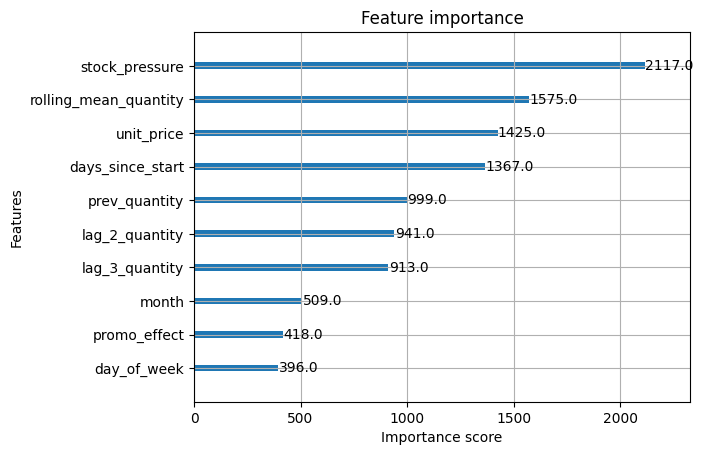

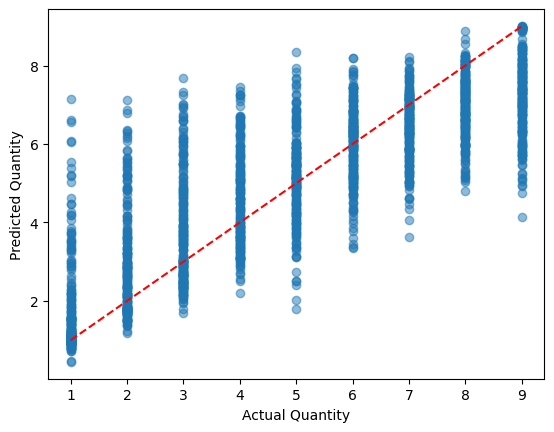

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Debug predictions
print("y_test mean:", y_test.mean(), "std:", y_test.std())
print("y_pred mean:", y_pred.mean(), "std:", y_pred.std())
print("Sample y_test vs y_pred:", list(zip(y_test[:5], y_pred[:5])))

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.2f}")
print(f"📈 RMSE: {rmse:.2f}")
print(f"🎯 R² Score: {r2:.2f}")

# Feature importance
xgb.plot_importance(model, max_num_features=10)
plt.show()

# Plot predictions vs actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [ ]:
import xgboost as xgb

# Save the trained XGBoost model safely
model.save_model("stock_replenishment.json")

print("✅ Model saved successfully as stock_replenishment.json")


✅ Model saved successfully as stock_replenishment.json


In [ ]:
import json

# Save the feature names to a JSON file
feature_info = {"features": list(X.columns)}
with open("stock_replenishment_features.json", "w") as f:
    json.dump(feature_info, f)

print("✅ Feature info saved successfully.")


✅ Feature info saved successfully.


In [ ]:
# Test model loading
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("stock_replenishment.json")

# Test a small prediction
sample_input = X_test.iloc[:1]
print("✅ Test Prediction:", loaded_model.predict(sample_input))


✅ Test Prediction: [3.285439]


Stock Replenishment Summary:
     Product_ID  Category Probable_Out_of_Stock_Date  Replenishment_Amount
0           100       0.0        Not within 2 months              0.000000
1           101       0.0        Not within 2 months              0.000000
2           102       0.0        Not within 2 months              0.000000
3           103       0.0        2025-05-26 00:00:00            268.634474
4           104       0.0        Not within 2 months              0.000000
..          ...       ...                        ...                   ...
894         994       0.0        Not within 2 months              0.000000
895         995       0.0        Not within 2 months              0.000000
896         996       0.0        2025-06-27 00:00:00             32.993372
897         997       0.0        2025-06-02 00:00:00            208.113872
898         998       0.0        Not within 2 months              0.000000

[899 rows x 4 columns]


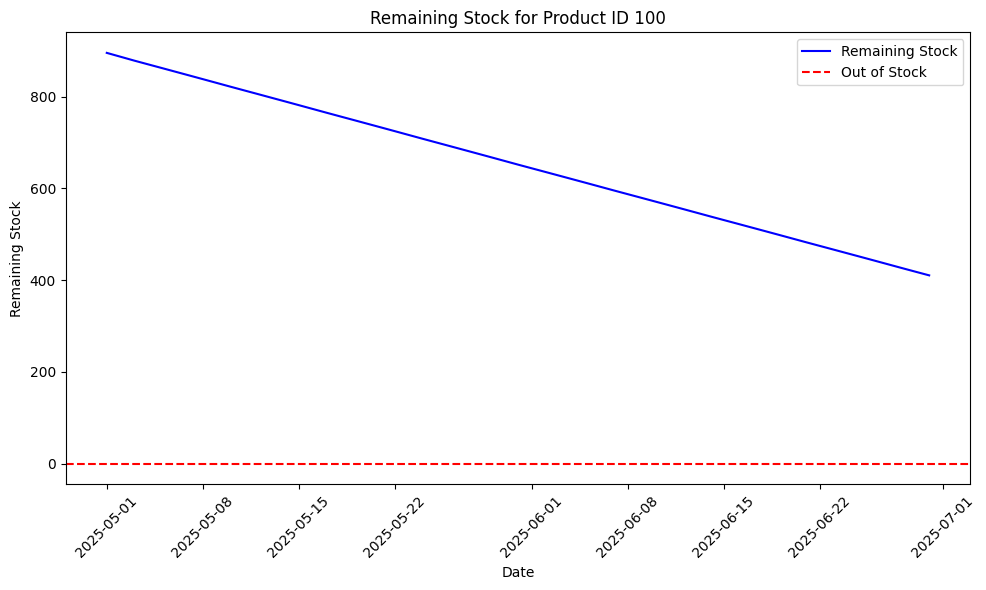

In [ ]:
# Set pandas option to handle future downcasting behavior
pd.set_option('future.no_silent_downcasting', True)

# Get the last row per product_id for future prediction base (including stock_level and category)
last_data = data_encoded.groupby('product_id').tail(1).copy()

# Create future dates (e.g., May 2025 to June 2025)
future_dates = pd.date_range(start='2025-05-01', end='2025-06-30', freq='D')
future_data = pd.DataFrame(index=range(len(future_dates) * len(last_data)), columns=data_encoded.columns)

# Populate future data
idx = 0
for _, row in last_data.iterrows():
    for date in future_dates:
        future_data.iloc[idx] = row
        future_data.loc[idx, 'date_of_purchase'] = date
        future_data.loc[idx, 'day_of_week'] = date.dayofweek
        future_data.loc[idx, 'month'] = date.month
        future_data.loc[idx, 'is_weekend'] = 1 if date.dayofweek >= 5 else 0
        future_data.loc[idx, 'days_since_start'] = (date - data['date_of_purchase'].min()).days
        idx += 1

# Recompute dynamic features for future data
future_data['prev_quantity'] = future_data.groupby('product_id')['quantity'].shift(1).ffill().fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['lag_2_quantity'] = future_data.groupby('product_id')['quantity'].shift(2).ffill().fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['lag_3_quantity'] = future_data.groupby('product_id')['quantity'].shift(3).ffill().fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['rolling_mean_quantity'] = future_data.groupby('product_id')['quantity'].transform(lambda x: x.rolling(7, min_periods=1).mean()).fillna(data['quantity'].mean()).infer_objects(copy=False)
future_data['price_change'] = future_data['unit_price'] - future_data['competitor_price']
future_data['stock_pressure'] = future_data['quantity'] / future_data['stock_level'].replace(0, 1)
future_data['promo_effect'] = future_data['is_promotion'] * future_data['marketing_spend']

# Handle missing values
future_data.fillna({'quantity': data['quantity'].mean(), 'prev_quantity': data['quantity'].mean(),
                    'lag_2_quantity': data['quantity'].mean(), 'lag_3_quantity': data['quantity'].mean(),
                    'rolling_mean_quantity': data['quantity'].mean(), 'price_change': 0,
                    'stock_pressure': 0, 'promo_effect': 0}, inplace=True)
future_data = future_data.infer_objects(copy=False)

# Align future data with training features
future_data_encoded = future_data.reindex(columns=data_encoded.columns, fill_value=0)

# Ensure numeric
for col in future_data_encoded.columns:
    if future_data_encoded[col].dtype == 'object':
        print(f"Warning: Column {col} is object. Converting to numeric.")
        future_data_encoded[col] = pd.to_numeric(future_data_encoded[col], errors='coerce').fillna(0)

# Align future data with training features
X_future = future_data_encoded[features]

# Predict future quantities
future_predictions = model.predict(X_future)

# Add predictions to future data
future_data_encoded['predicted_quantity'] = future_predictions

# Calculate stock replenishment per product_id and category
replenishment_summary = []

for pid in last_data['product_id'].unique():
    pid_data = future_data_encoded[future_data_encoded['product_id'] == pid].copy()
    initial_stock = last_data[last_data['product_id'] == pid]['stock_level'].iloc[0]
    category = last_data[last_data['product_id'] == pid]['category'].iloc[0] if 'category' in last_data.columns else 'Unknown'
    pid_data['cumulative_demand'] = pid_data['predicted_quantity'].cumsum()
    pid_data['remaining_stock'] = initial_stock - pid_data['cumulative_demand']

    # Find probable out-of-stock date (first day remaining_stock <= 0)
    out_of_stock_date = pid_data[pid_data['remaining_stock'] <= 0]['date_of_purchase'].iloc[0] if not pid_data[pid_data['remaining_stock'] <= 0].empty else 'Not within 2 months'

    # Total demand over the 2 months
    total_demand = pid_data['predicted_quantity'].sum()
    safety_stock = 0.1 * data[data['product_id'] == pid]['quantity'].mean()  # 10% of average demand
    replenishment_amount = max(0, total_demand + safety_stock - initial_stock)

    replenishment_summary.append({
        'Product_ID': pid,
        'Category': category,
        'Probable_Out_of_Stock_Date': out_of_stock_date,
        'Replenishment_Amount': replenishment_amount
    })

# Create summary DataFrame
replenishment_df = pd.DataFrame(replenishment_summary)

print("Stock Replenishment Summary:")
print(replenishment_df)

# Optional: Plot remaining stock for one product (example)
pid_example = last_data['product_id'].iloc[0]
pid_data_example = future_data_encoded[future_data_encoded['product_id'] == pid_example].copy()
initial_stock = last_data[last_data['product_id'] == pid_example]['stock_level'].iloc[0]
pid_data_example['cumulative_demand'] = pid_data_example['predicted_quantity'].cumsum()
pid_data_example['remaining_stock'] = initial_stock - pid_data_example['cumulative_demand']

plt.figure(figsize=(10, 6))
plt.plot(pid_data_example['date_of_purchase'], pid_data_example['remaining_stock'], label='Remaining Stock', color='b')
plt.axhline(y=0, color='r', linestyle='--', label='Out of Stock')
plt.xlabel('Date')
plt.ylabel('Remaining Stock')
plt.title(f'Remaining Stock for Product ID {pid_example}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# # Standardize features only
# scaler_X = StandardScaler()
# X_scaled = scaler_X.fit_transform(X).astype('float32')

# # scaler_y = MinMaxScaler()
# # y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten().astype('float32')

In [ ]:
# # Create sequences (unscaled y)
# def create_sequences(data, features, target, seq_length=7):
#     X_seq, y_seq = [], []
#     for pid in data['product_id'].unique():
#         pid_data = data[data['product_id'] == pid]
#         pid_X = pid_data[features].values.astype('float32')
#         pid_y = pid_data[target].values.astype('float32')
#         if len(pid_X) >= seq_length:  # Only include sequences with enough data
#             for i in range(len(pid_X) - seq_length + 1):
#                 X_seq.append(pid_X[i:i+seq_length])
#                 y_seq.append(pid_y[i+seq_length-1])
#     return np.array(X_seq), np.array(y_seq)

# seq_length = 7
# X_seq, y_seq = create_sequences(data_encoded, features, target, seq_length)

In [ ]:
# # Debug data
# print("X_seq shape:", X_seq.shape, "dtype:", X_seq.dtype)
# print("y_seq mean:", y_seq.mean(), "std:", y_seq.std())
# print("Sample y_seq:", y_seq[:5])

In [ ]:
# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# # Build LSTM model
# model = Sequential([
#     LSTM(128, input_shape=(seq_length, X_train.shape[2]), return_sequences=False, kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.1),
#     Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
#     Dense(1)
# ])

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# # Callbacks
# early_stopping = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, verbose=1, mode='min')
# lr_scheduler = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=15, min_lr=1e-6, verbose=1, mode='min')

# # Train model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=200,
#     batch_size=32,
#     callbacks=[early_stopping, lr_scheduler],
#     verbose=1
# )

In [ ]:
# # Predict
# y_pred = model.predict(X_test).flatten()

# # Predict and inverse-transform
# # y_pred_scaled = model.predict(X_test).flatten()
# # y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
# # y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
# # Debug predictions
# print("y_test mean:", y_test.mean(), "std:", y_test.std())
# print("y_pred mean:", y_pred.mean(), "std:", y_pred.std())
# print("Sample y_test vs y_pred:", list(zip(y_test[:5], y_pred[:5])))

In [ ]:
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"📊 MAE: {mae:.2f}")
# print(f"📈 RMSE: {rmse:.2f}")
# print(f"🎯 R² Score: {r2:.2f}")

In [ ]:
# # Plot training history
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# # Plot predictions vs actual
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.xlabel('Actual Quantity')
# plt.ylabel('Predicted Quantity')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.show()

In [ ]:
# # Set pandas option to handle future downcasting behavior
# pd.set_option('future.no_silent_downcasting', True)

# # Get the last sequence per product_id for future prediction base
# last_sequences = []
# for pid in data_encoded['product_id'].unique():
#     pid_data = data_encoded[data_encoded['product_id'] == pid].tail(seq_length)
#     if len(pid_data) == seq_length:
#         last_seq = pid_data[features].values.astype('float32')
#         last_sequences.append(last_seq)

# last_sequences = np.array(last_sequences)

# # Create future dates (e.g., May 2025 to June 2025)
# future_dates = pd.date_range(start='2025-05-01', end='2025-06-30', freq='D')
# n_future_days = len(future_dates)
# future_predictions = []

# # Predict future quantities using the last sequences
# for seq in last_sequences:
#     current_seq = seq.copy()
#     for _ in range(n_future_days):
#         next_pred = model.predict(current_seq.reshape(1, seq_length, -1), verbose=0)[0][0]
#         future_predictions.append(next_pred)
#         # Shift sequence and append prediction
#         current_seq = np.roll(current_seq, -1, axis=0)
#         current_seq[-1] = current_seq[-2].copy()  # Use previous values for features
#         current_seq[-1, features.index('prev_quantity')] = next_pred  # Update prev_quantity

# # Create future DataFrame
# future_df = pd.DataFrame({
#     'date_of_purchase': future_dates.repeat(len(data_encoded['product_id'].unique())),
#     'product_id': np.tile(data_encoded['product_id'].unique(), n_future_days),
#     'predicted_quantity': future_predictions
# })

# # Merge with last known data to get stock_level and category
# last_data = data_encoded.groupby('product_id').tail(1)[['product_id', 'stock_level', 'category']].reset_index(drop=True)
# future_df = future_df.merge(last_data, on='product_id', how='left')

# # Calculate stock replenishment per product_id and category
# replenishment_summary = []

# for pid in last_data['product_id'].unique():
#     pid_data = future_df[future_df['product_id'] == pid].copy()
#     initial_stock = last_data[last_data['product_id'] == pid]['stock_level'].iloc[0]
#     category = last_data[last_data['product_id'] == pid]['category'].iloc[0] if 'category' in last_data.columns else 'Unknown'
#     pid_data['cumulative_demand'] = pid_data['predicted_quantity'].cumsum()
#     pid_data['remaining_stock'] = initial_stock - pid_data['cumulative_demand']

#     # Find probable out-of-stock date (first day remaining_stock <= 0)
#     out_of_stock_date = pid_data[pid_data['remaining_stock'] <= 0]['date_of_purchase'].iloc[0] if not pid_data[pid_data['remaining_stock'] <= 0].empty else 'Not within 2 months'

#     # Total demand over the 2 months
#     total_demand = pid_data['predicted_quantity'].sum()
#     safety_stock = 0.1 * data[data['product_id'] == pid]['quantity'].mean()  # 10% of average demand
#     replenishment_amount = max(0, total_demand + safety_stock - initial_stock)

#     replenishment_summary.append({
#         'Product_ID': pid,
#         'Category': category,
#         'Probable_Out_of_Stock_Date': out_of_stock_date,
#         'Replenishment_Amount': replenishment_amount
#     })

# # Create summary DataFrame
# replenishment_df = pd.DataFrame(replenishment_summary)

# print("Stock Replenishment Summary (LSTM):")
# print(replenishment_df)

# # Optional: Plot remaining stock for one product (example)
# pid_example = last_data['product_id'].iloc[0]
# pid_data_example = future_df[future_df['product_id'] == pid_example].copy()
# initial_stock = last_data[last_data['product_id'] == pid_example]['stock_level'].iloc[0]
# pid_data_example['cumulative_demand'] = pid_data_example['predicted_quantity'].cumsum()
# pid_data_example['remaining_stock'] = initial_stock - pid_data_example['cumulative_demand']

# plt.figure(figsize=(10, 6))
# plt.plot(pid_data_example['date_of_purchase'], pid_data_example['remaining_stock'], label='Remaining Stock', color='b')
# plt.axhline(y=0, color='r', linestyle='--', label='Out of Stock')
# plt.xlabel('Date')
# plt.ylabel('Remaining Stock')
# plt.title(f'Remaining Stock for Product ID {pid_example} (LSTM)')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
import pickle

# Save the trained XGBoost model
with open('stock_replinishment .pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ XGBoost model saved to xgboost_model.pkl")


✅ XGBoost model saved to xgboost_model.pkl
